<a href="https://colab.research.google.com/github/constantbourdrez/DL_ESPCI/blob/main/ADL_lab_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a refresher of the lab sessions of 2A course on deep learning. You will use the CIFAR10 dataset. It can be a bit long to download. **So start by downloading the dataset**.

**Objectives:**
- Reminder on how to build and train a simple neural network
- Colored images classification with CIFAR-10
- Convolutional Networks (with pooling, batch-norm)
- ResNet architecture

**Reminder on notebook:**
This notebook is a template of what could be explored. You can follow it or explore and experiment additional things.

Use the notebook to add your comments, figures, .... You can remove and reorganize it as you wish. The goal is for you to make a nice report. The important points are to:
- understand what you will write
- explain the experimental results
- the code should be clean and well documented
- when copy many times the same code, take the time to create a function instead.

In [1]:
# math, numpy and plot
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
# torch
import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
#tqdm
from tqdm import tqdm
#seaborn
import seaborn as sns

# Dataset: CIFAR-10

First the dataset !  Remind that in pytorch for images, we expect the data set to be a Tensor with 4 dimensions $(N,C,H,W)$ with :
- N the batch dimension, *i.e* the number of images
- C the number of input channels, here it is 3
- H the height or number of rows of each image
- W the width  or number of columns of each image




To experiment image classification on a coloured image, we can use the CIFAR-10 dataset.
You can find more details for instance on this page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. We can download the dataset with a dataloader directly:

With this example we will use a **dataset** via a **dataloader**.  This is a convenient tool to handle datasets with efficient iterators. There is a [tutorial here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). But for the moment, you can just follow the next cells.

In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 42062244.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
batch_size = 200

trainloader = th.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = th.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Look at some images

In [4]:
def imshow(img,small=True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fs = None
    if small:
        fs = (2,2)
    else:
        fs = (16,16)
    fig , ax= plt.subplots(figsize=fs)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


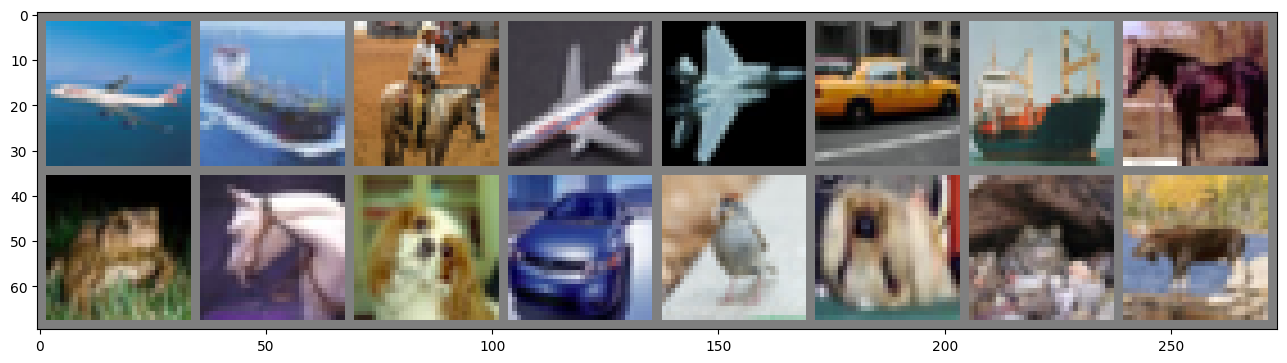

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]),small=False)

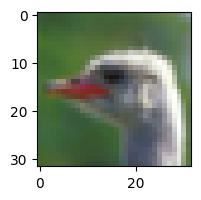

In [6]:
imshow(trainset[2343][0])

## Training a simple model

As we did last year, it is usefull to write a function for the training procedure and another one to compute the validation score. You can start from what you did last year.

**TODO**:
- Two functions, one to compute the validation score and the other to train a model.
- And try them on a simple Sequential model made of:
    - A convolution with 32 output channels, kernel_size=(7,7),stride=(2,2), padding=(3,3), and bias=False
    - Then a classfier with one hidden layer
- Select the loss and the optimizer as well


In [7]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

In [11]:
def validation_score(model, dsetloader, gpu = True):
    """Compute the classification accuracy and the loss function on the validation set """

    #define the criterion used to compute the validation score

    criterion = nn.CrossEntropyLoss()


    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with th.no_grad():
        for inputs, labels in dsetloader:
          if gpu:
            inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)


          running_loss += loss.item()

          _, predicted = th.max(outputs, 1)
          correct_predictions += (predicted == labels).sum().item()
          total_samples += labels.size(0)

    average_loss = running_loss / len(dsetloader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy


In [81]:
def trainer(model, trainsetloader, validsetloader, lr=1e-4, nepoch=10, gpu = True):
    """This function trains
    - a pytorch model
    - on a train data set given its dataloader (trainsetloader)
    - after each epoch the validation score is computed (validsetloader)
    - lr = the initial learning rate of Adam
    - nepoch : the number of epochs for training
    """

    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, valid_losses, accuracies = [], [], []

    for epoch in tqdm(range(nepoch)):
      running_loss = 0
      for inputs, labels in trainsetloader:
        if gpu:
          inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

      train_loss = running_loss / len(trainsetloader)

      average_loss, accuracy = validation_score(model, validsetloader)
      valid_losses.append(average_loss)
      accuracies.append(accuracy)
      train_losses.append(train_loss)

      print(f"Epoch {epoch + 1}/{nepoch} -> "
            f"Train Loss: {train_loss:.4f}, "
            f"Validation Loss: {average_loss:.4f}, "
            f"Validation Accuracy: {accuracy:.4f}")


    return model,train_losses, valid_losses, accuracies

In [82]:
simple_model = nn.Sequential(nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),
                             nn.ReLU(inplace=True),
                             nn.Flatten(),
                             nn.Linear(32 * 16 * 16, 128),
                             nn.ReLU(inplace=True),
                             nn.Linear(128, len(classes))
                             )

simple_model = simple_model.to(device)


In [14]:
simple_model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): ReLU(inplace=True)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=8192, out_features=128, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [83]:
trained_model = trainer(simple_model, trainloader, testloader)

 10%|█         | 1/10 [00:15<02:20, 15.67s/it]

Epoch 1/10 -> Train Loss: 1.7701, Validation Loss: 1.5797, Validation Accuracy: 0.4500


 20%|██        | 2/10 [00:31<02:03, 15.50s/it]

Epoch 2/10 -> Train Loss: 1.5034, Validation Loss: 1.4394, Validation Accuracy: 0.4952


 30%|███       | 3/10 [00:46<01:48, 15.55s/it]

Epoch 3/10 -> Train Loss: 1.3919, Validation Loss: 1.3640, Validation Accuracy: 0.5233


 40%|████      | 4/10 [01:02<01:34, 15.70s/it]

Epoch 4/10 -> Train Loss: 1.3219, Validation Loss: 1.3209, Validation Accuracy: 0.5389


 50%|█████     | 5/10 [01:17<01:17, 15.43s/it]

Epoch 5/10 -> Train Loss: 1.2721, Validation Loss: 1.2956, Validation Accuracy: 0.5449


 60%|██████    | 6/10 [01:32<01:01, 15.32s/it]

Epoch 6/10 -> Train Loss: 1.2292, Validation Loss: 1.2715, Validation Accuracy: 0.5597


 70%|███████   | 7/10 [01:47<00:45, 15.31s/it]

Epoch 7/10 -> Train Loss: 1.1899, Validation Loss: 1.2452, Validation Accuracy: 0.5637


 80%|████████  | 8/10 [02:03<00:30, 15.26s/it]

Epoch 8/10 -> Train Loss: 1.1557, Validation Loss: 1.2276, Validation Accuracy: 0.5707


 90%|█████████ | 9/10 [02:18<00:15, 15.45s/it]

Epoch 9/10 -> Train Loss: 1.1236, Validation Loss: 1.2087, Validation Accuracy: 0.5770


100%|██████████| 10/10 [02:34<00:00, 15.40s/it]

Epoch 10/10 -> Train Loss: 1.0876, Validation Loss: 1.1956, Validation Accuracy: 0.5854


Text(0, 0.5, 'CrossEntropy')

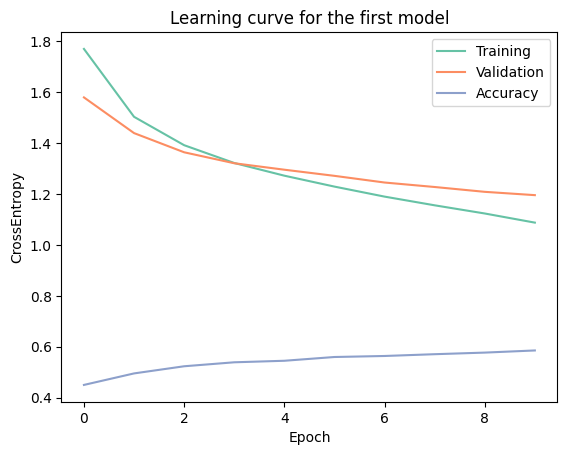

In [84]:
model, train_losses, valid_losses, accuracies = trained_model

#Plot the results
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the first model')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')

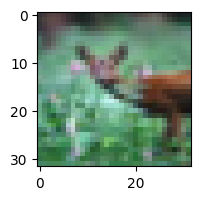

Probabilities: tensor([0.1229, 0.1261, 0.0904, 0.0219, 0.1857, 0.0446, 0.1427, 0.0467, 0.2008,
        0.0183], device='cuda:0'), Predicted label: 8, Real label: 4


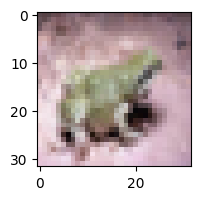

Probabilities: tensor([2.7176e-03, 1.4734e-03, 3.3354e-03, 5.5198e-02, 1.9134e-02, 4.4139e-02,
        8.6554e-01, 2.5327e-03, 7.6501e-04, 5.1625e-03], device='cuda:0'), Predicted label: 6, Real label: 6


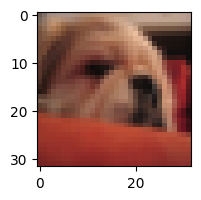

Probabilities: tensor([0.0135, 0.0057, 0.0323, 0.2117, 0.0426, 0.4056, 0.2144, 0.0463, 0.0008,
        0.0272], device='cuda:0'), Predicted label: 5, Real label: 5


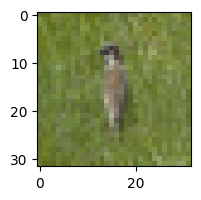

Probabilities: tensor([2.9256e-02, 1.2637e-03, 3.0248e-01, 2.5653e-02, 3.6407e-01, 2.4457e-02,
        2.4093e-01, 1.1158e-02, 8.8833e-05, 6.4164e-04], device='cuda:0'), Predicted label: 4, Real label: 2


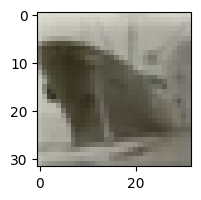

Probabilities: tensor([0.0355, 0.0277, 0.0438, 0.1381, 0.0790, 0.0713, 0.2919, 0.0741, 0.0553,
        0.1834], device='cuda:0'), Predicted label: 6, Real label: 8


In [85]:
 random_idx = np.random.randint(0, len(trainset), 5)
 for idx in random_idx:
  imshow(trainset[idx][0])
  model.eval()  # Set the model to evaluation mode
  with th.no_grad():
      input_image = trainset[idx][0].unsqueeze(0).to(device)
      output = model(input_image)


  probabilities = th.nn.functional.softmax(output[0], dim=0)
  print(f'Probabilities: {probabilities}, Predicted label: {np.argmax(probabilities.cpu())}, Real label: {trainset[idx][1]}')


The model seems to have difficulties to classify images, for instance only 1 prediction out of 5 here is correct. The architecture or the number of Epoch neeeds to be changed (increased for Epoch).

In [86]:
simple_model = nn.Sequential(nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),
                             nn.ReLU(inplace=True),
                             nn.Flatten(),
                             nn.Linear(32 * 16 * 16, 128),
                             nn.ReLU(inplace=True),
                             nn.Linear(128, len(classes))
                             )

simple_model = simple_model.to(device)

  3%|▎         | 1/30 [00:15<07:15, 15.00s/it]

Epoch 1/30 -> Train Loss: 1.7513, Validation Loss: 1.5578, Validation Accuracy: 0.4514


  7%|▋         | 2/30 [00:30<07:00, 15.01s/it]

Epoch 2/30 -> Train Loss: 1.4801, Validation Loss: 1.4196, Validation Accuracy: 0.5020


 10%|█         | 3/30 [00:45<06:45, 15.04s/it]

Epoch 3/30 -> Train Loss: 1.3769, Validation Loss: 1.3691, Validation Accuracy: 0.5171


 13%|█▎        | 4/30 [01:00<06:31, 15.07s/it]

Epoch 4/30 -> Train Loss: 1.3186, Validation Loss: 1.3360, Validation Accuracy: 0.5337


 17%|█▋        | 5/30 [01:15<06:21, 15.26s/it]

Epoch 5/30 -> Train Loss: 1.2745, Validation Loss: 1.3049, Validation Accuracy: 0.5412


 20%|██        | 6/30 [01:30<06:05, 15.21s/it]

Epoch 6/30 -> Train Loss: 1.2358, Validation Loss: 1.2778, Validation Accuracy: 0.5557


 23%|██▎       | 7/30 [01:46<05:49, 15.18s/it]

Epoch 7/30 -> Train Loss: 1.2015, Validation Loss: 1.2624, Validation Accuracy: 0.5562


 27%|██▋       | 8/30 [02:01<05:33, 15.16s/it]

Epoch 8/30 -> Train Loss: 1.1698, Validation Loss: 1.2538, Validation Accuracy: 0.5581


 30%|███       | 9/30 [02:16<05:18, 15.18s/it]

Epoch 9/30 -> Train Loss: 1.1407, Validation Loss: 1.2261, Validation Accuracy: 0.5769


 33%|███▎      | 10/30 [02:31<05:03, 15.19s/it]

Epoch 10/30 -> Train Loss: 1.1105, Validation Loss: 1.2111, Validation Accuracy: 0.5749


 37%|███▋      | 11/30 [02:47<04:51, 15.36s/it]

Epoch 11/30 -> Train Loss: 1.0847, Validation Loss: 1.2102, Validation Accuracy: 0.5763


 40%|████      | 12/30 [03:02<04:34, 15.24s/it]

Epoch 12/30 -> Train Loss: 1.0567, Validation Loss: 1.1904, Validation Accuracy: 0.5855


 43%|████▎     | 13/30 [03:17<04:18, 15.19s/it]

Epoch 13/30 -> Train Loss: 1.0314, Validation Loss: 1.1816, Validation Accuracy: 0.5904


 47%|████▋     | 14/30 [03:32<04:01, 15.07s/it]

Epoch 14/30 -> Train Loss: 1.0068, Validation Loss: 1.1670, Validation Accuracy: 0.5943


 50%|█████     | 15/30 [03:47<03:45, 15.06s/it]

Epoch 15/30 -> Train Loss: 0.9841, Validation Loss: 1.1613, Validation Accuracy: 0.6008


 53%|█████▎    | 16/30 [04:02<03:31, 15.09s/it]

Epoch 16/30 -> Train Loss: 0.9611, Validation Loss: 1.1673, Validation Accuracy: 0.5905


 57%|█████▋    | 17/30 [04:18<03:19, 15.31s/it]

Epoch 17/30 -> Train Loss: 0.9383, Validation Loss: 1.1466, Validation Accuracy: 0.6023


 60%|██████    | 18/30 [04:33<03:01, 15.16s/it]

Epoch 18/30 -> Train Loss: 0.9164, Validation Loss: 1.1489, Validation Accuracy: 0.6055


 63%|██████▎   | 19/30 [04:47<02:45, 15.09s/it]

Epoch 19/30 -> Train Loss: 0.8956, Validation Loss: 1.1391, Validation Accuracy: 0.6056


 67%|██████▋   | 20/30 [05:03<02:30, 15.09s/it]

Epoch 20/30 -> Train Loss: 0.8735, Validation Loss: 1.1288, Validation Accuracy: 0.6099


 70%|███████   | 21/30 [05:18<02:16, 15.14s/it]

Epoch 21/30 -> Train Loss: 0.8545, Validation Loss: 1.1230, Validation Accuracy: 0.6129


 73%|███████▎  | 22/30 [05:33<02:02, 15.26s/it]

Epoch 22/30 -> Train Loss: 0.8331, Validation Loss: 1.1343, Validation Accuracy: 0.6068


 77%|███████▋  | 23/30 [05:49<01:47, 15.29s/it]

Epoch 23/30 -> Train Loss: 0.8149, Validation Loss: 1.1141, Validation Accuracy: 0.6200


 80%|████████  | 24/30 [06:04<01:31, 15.24s/it]

Epoch 24/30 -> Train Loss: 0.7975, Validation Loss: 1.1184, Validation Accuracy: 0.6161


 83%|████████▎ | 25/30 [06:19<01:15, 15.17s/it]

Epoch 25/30 -> Train Loss: 0.7779, Validation Loss: 1.1129, Validation Accuracy: 0.6211


 87%|████████▋ | 26/30 [06:34<01:00, 15.11s/it]

Epoch 26/30 -> Train Loss: 0.7613, Validation Loss: 1.1130, Validation Accuracy: 0.6188


 90%|█████████ | 27/30 [06:49<00:45, 15.12s/it]

Epoch 27/30 -> Train Loss: 0.7423, Validation Loss: 1.1134, Validation Accuracy: 0.6179


 93%|█████████▎| 28/30 [07:05<00:30, 15.35s/it]

Epoch 28/30 -> Train Loss: 0.7251, Validation Loss: 1.1178, Validation Accuracy: 0.6215


 97%|█████████▋| 29/30 [07:20<00:15, 15.27s/it]

Epoch 29/30 -> Train Loss: 0.7067, Validation Loss: 1.1147, Validation Accuracy: 0.6268


100%|██████████| 30/30 [07:35<00:00, 15.18s/it]

Epoch 30/30 -> Train Loss: 0.6907, Validation Loss: 1.1125, Validation Accuracy: 0.6249


Text(0, 0.5, 'CrossEntropy')

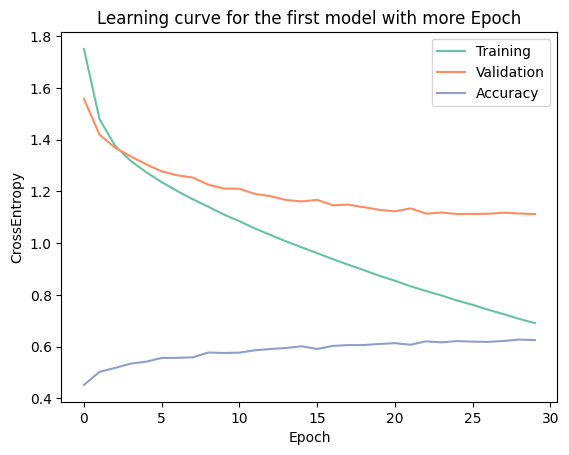

In [87]:
#Training with more Epoch

trained_model = trainer(simple_model, trainloader, testloader, nepoch = 30)
model, train_losses, valid_losses, accuracies = trained_model

#Plot the results
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the first model with more Epoch')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')

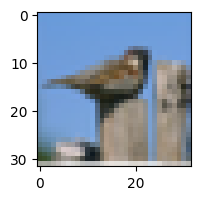

Probabilities: tensor([4.2693e-02, 1.7283e-04, 9.0433e-01, 1.1819e-03, 4.4568e-02, 8.5138e-04,
        3.3184e-04, 4.4359e-03, 1.4051e-03, 3.0259e-05], device='cuda:0'), Predicted label: 2, Real label: 2


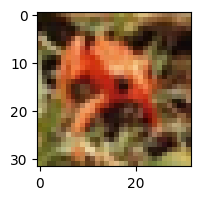

Probabilities: tensor([1.5850e-03, 4.7874e-03, 1.3419e-03, 1.5498e-03, 4.6043e-02, 2.1422e-02,
        1.8835e-01, 6.7551e-01, 8.7502e-06, 5.9400e-02], device='cuda:0'), Predicted label: 7, Real label: 6


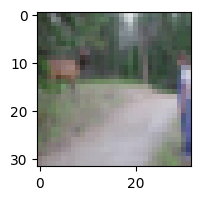

Probabilities: tensor([0.0279, 0.0064, 0.0365, 0.4574, 0.2046, 0.1004, 0.0577, 0.0039, 0.0992,
        0.0060], device='cuda:0'), Predicted label: 3, Real label: 4


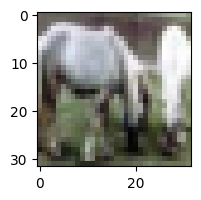

Probabilities: tensor([0.0240, 0.0095, 0.0761, 0.0635, 0.0761, 0.2319, 0.0180, 0.4759, 0.0024,
        0.0226], device='cuda:0'), Predicted label: 7, Real label: 7


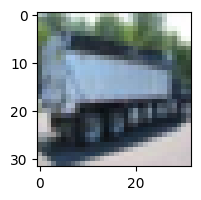

Probabilities: tensor([3.2700e-04, 2.9105e-01, 8.9474e-04, 1.3044e-04, 2.3178e-06, 2.6440e-06,
        8.3498e-05, 1.0708e-05, 6.9531e-03, 7.0054e-01], device='cuda:0'), Predicted label: 9, Real label: 9


In [88]:
 random_idx = np.random.randint(0, len(trainset), 5)
 for idx in random_idx:
  imshow(trainset[idx][0])
  model.eval()  # Set the model to evaluation mode
  with th.no_grad():
      input_image = trainset[idx][0].unsqueeze(0).to(device)
      output = model(input_image)


  probabilities = th.nn.functional.softmax(output[0], dim=0)
  print(f'Probabilities: {probabilities}, Predicted label: {np.argmax(probabilities.cpu())}, Real label: {trainset[idx][1]}')

Still wrong results, the accuracy seems to have converged. The training loop also looks like it is finished. A change in architecture is definitely reasonable.

# ResNet (simplified) on CIFAR10

ResNet is a famous architecture and still state of the art for image classification and object detection. The
[original ResNet paper](https://arxiv.org/abs/1512.03385) describes the principles and you will find below an overview.

The dataset is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset gathers images in colors. To plot the images look at the end of the second lab session on convolution (the notebook). CIFAR10 image classification dataset consists of 50k training  images and 10k testing images in 10 classes. The network inputs are $32\times 32$ images, with the per-pixel mean subtracted.

## ResNet models

ResNet relies on what we call ResNet blocks. A ResNet block is typically a convolutional block with a residual connection. A major obstacle in training deeper neural networks is the well-known  vanishing gradien problem: as  layers are added to the network the
multiplying gradients during the backward pass yields very small gradients for the first layers (more or less like noise).

The ResNet architecture is an attempt to tackle this strong issue. Let start by the definition of a Residual block:

<img align="center" src="https://drive.google.com/uc?id=1c4QvJN4H_GdGWNM-vW46j_JIG64CD_mD" />

In the previous figure, the input is $X$ and the output is $\mathcal{F}(X)+X$ followed by a Relu. $\mathcal{F}$ is a convolutional block.
The residual block have some nice properties for the gradient backpropagation (see the course). A cascade of these residual blocks is used
to create very deep CNN models with more than 100
layers as presented in the original ResNet paper.

The authors of the original paper train and test six different ResNet architectures on CIFAR10 and
compare the results.
The tested depth are $20,32,44,56,110$. Here are the results:


| MODEL | %error   |
|------|------|
|   ResNet-20  | 8.75|
|   ResNet-32  |7.51 |
|   ResNet-44  |7.17|
|   ResNet-56  |6.97 |
|   ResNet-110  | 6.43|

# A simplified ResNet model

In this lab, your goal is to implement a ResNet like architecture. We will simplify a little the architecture.

## Architecture
The overall architecure can be decomposed in 3 parts: intput, a cascade of residual blocks, and the classification.
### The input parts
The first layers are quite regular:
- The images are fed to a convolutional network (input_channels = 3, output_channels=16, kernel_size=7, stride=2, padding=3, bias=False) followed by a relu activation.
- Then we will apply a batch normalization.

### A cascade of residual blocks
To define a residual block, let us first define $\mathcal{F}$:
- A first convolution (in_channels = out_channels = 64, kernel_size=3, stride=1, padding=1, bias=False) followed by a Relu.
- And Batch Norm.
- Then we add another convolution layer (with the same hyperparameters) followed by a Relu and another BatchNorm.

The output of the residual block includes the residual connection :
$$out = relu(x + \mathcal{F}(x))$$
Note that each residual block defines its own function $\mathcal{F}$, and therefore its own set of parameters.


### Classification
At the end of this cascade, we can add a final Linear layer to make the classification.

## Implementation
A good idea is to first define *BasicBlock* (as a pytorch *Module* or you can write a function that builds such block). This block implements $\mathcal{F}$ as described before.
Then you can implement a *ResNet*  class  that includes the different parts previouly described:
- input part
- a list of *BasicBlock* (the number **n** of these blocks should be a parameter of the constructor)
- the output classifier.

# TODO
Implement a ResNet classifier on CIFAR10.

- Starts with $n=2$ residual blocks
- Find an adapted learning rate by testing different values.
- Then Increase $n$ to 5, 10 and 20.
- For high $n$, run the code on Colab using GPUs. For that purpose all the Tensors used during training and valid, along with the models should be transfered on GPU (see the course).



In [89]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, n):
        super(ResNet, self).__init__()
        self.conv_initial = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(16)
        self.conv1x1 = nn.Conv2d(16, 64, kernel_size=1, bias=False)
        self.cascade = self._make_cascade(n)
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, len(classes))

    def _make_cascade(self, n):
        layers = [BasicBlock() for _ in range(n)]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv_initial(x)
        out = self.relu(out)
        out = self.bn(out)
        out = self.conv1x1(out)
        out = self.cascade(out)
        out = self.global_avg_pooling(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [90]:
tmp = ResNet(2).to(device)

In [91]:
resnet2 = trainer(tmp, trainloader, testloader, nepoch = 10)

 10%|█         | 1/10 [00:20<03:04, 20.53s/it]

Epoch 1/10 -> Train Loss: 1.7804, Validation Loss: 1.5946, Validation Accuracy: 0.4463


 20%|██        | 2/10 [00:44<03:01, 22.64s/it]

Epoch 2/10 -> Train Loss: 1.4368, Validation Loss: 1.3371, Validation Accuracy: 0.5184


 30%|███       | 3/10 [01:03<02:26, 20.86s/it]

Epoch 3/10 -> Train Loss: 1.3054, Validation Loss: 1.2691, Validation Accuracy: 0.5469


 40%|████      | 4/10 [01:22<02:01, 20.20s/it]

Epoch 4/10 -> Train Loss: 1.2349, Validation Loss: 1.2285, Validation Accuracy: 0.5626


 50%|█████     | 5/10 [01:41<01:38, 19.73s/it]

Epoch 5/10 -> Train Loss: 1.1843, Validation Loss: 1.1793, Validation Accuracy: 0.5766


 60%|██████    | 6/10 [02:00<01:18, 19.50s/it]

Epoch 6/10 -> Train Loss: 1.1430, Validation Loss: 1.1415, Validation Accuracy: 0.5963


 70%|███████   | 7/10 [02:19<00:58, 19.37s/it]

Epoch 7/10 -> Train Loss: 1.1104, Validation Loss: 1.1224, Validation Accuracy: 0.6035


 80%|████████  | 8/10 [02:38<00:38, 19.11s/it]

Epoch 8/10 -> Train Loss: 1.0745, Validation Loss: 1.0934, Validation Accuracy: 0.6073


 90%|█████████ | 9/10 [02:57<00:19, 19.27s/it]

Epoch 9/10 -> Train Loss: 1.0485, Validation Loss: 1.0694, Validation Accuracy: 0.6170


100%|██████████| 10/10 [03:16<00:00, 19.66s/it]

Epoch 10/10 -> Train Loss: 1.0173, Validation Loss: 1.0412, Validation Accuracy: 0.6328


Text(0, 0.5, 'CrossEntropy')

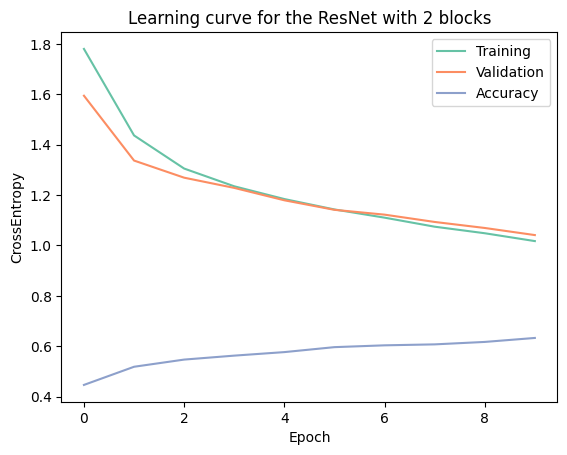

In [92]:
model, train_losses, valid_losses, accuracies = resnet2

#Plot the results
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the ResNet with 2 blocks')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')